# 1) Population Projection by Region 
In the below notebook I will take a datasets  titled "PEA04" and "PEA07" taken from the CSO website which contains details of the population in the Republic of Ireland by Region and perform some basic data anaslysis before implementing a few regression models. 

#### Section 1.1: Introduction

In [59]:
#Install relevant liabraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge

In [60]:
#Suppress warnings
import warnings
warnings.filterwarnings('ignore') 

#### Section 1.2: Data Preparation

I found 2 datasets on the CSO website (PEA04 & PEA07) which I can join in order to get population by region from 1996 - 2023. 

In [61]:
#Read in datasets as a dataframe
df1 = pd.read_csv("Dataset 1) PEA04.csv")
df2 = pd.read_csv("Dataset 2) PEA07.csv")

Source: https://data.cso.ie/#

In [62]:
#Trimming df1 by removing unnecessary columns
selected_columns = ['Age Group', 'Sex', 'Region', 'Year', 'VALUE']
df1 = df1[selected_columns]

In [63]:
#Trimming df2 by removing unnecessary columns
selected_columns = ['Age Group', 'Sex', 'Regional Authority Area', 'Year', 'VALUE']
df2 = df2[selected_columns]

In [64]:
# Renaming a column in df2 as it doesn't match df1
df2 = df2.rename(columns={'Regional Authority Area': 'Region'})

In [65]:
df1['Year'].unique(), df2['Year'].unique()

# df1 extends from 2011-2023
# df2 extends from 1996-2017
# Therefore I will have to cut out some of the data from df2

(array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
        2022, 2023], dtype=int64),
 array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017],
       dtype=int64))

In [66]:
# Remove df2 data from after 2011 to ensure no duplicated data
df2 = df2[df2['Year'] < 2011]

In [67]:
# Joining the dfs
df = pd.concat([df2, df1], ignore_index=True)

In [68]:
# Check
df['Year'].unique()

# So now I have a larger dataset going from 1996-2023

array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021, 2022, 2023], dtype=int64)

#### Section 1.3: Data Analysis

In [69]:
print(df.head())

     Age Group         Sex Region  Year  VALUE
0  0 - 4 years  Both sexes  State  1996  250.4
1  0 - 4 years  Both sexes  State  1997  250.0
2  0 - 4 years  Both sexes  State  1998  253.7
3  0 - 4 years  Both sexes  State  1999  259.8
4  0 - 4 years  Both sexes  State  2000  266.2


In [70]:
#Assess Dataset 
print(df.describe())
print(df.shape)

               Year         VALUE
count  14364.000000  14364.000000
mean    2009.500000     68.901079
std        8.078028    257.873503
min     1996.000000      0.600000
25%     2002.750000     11.200000
50%     2009.500000     18.000000
75%     2016.250000     37.300000
max     2023.000000   5281.600000
(14364, 5)


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14364 entries, 0 to 14363
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age Group  14364 non-null  object 
 1   Sex        14364 non-null  object 
 2   Region     14364 non-null  object 
 3   Year       14364 non-null  int64  
 4   VALUE      14364 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 561.2+ KB


In [72]:
#Checking columns
df["Age Group"].unique(), df["Sex"].unique(), df["Year"].unique(), df["Region"].unique()

# All unique column values appear reasonable but we will have to remove some of the 'totalled' data

(array(['0 - 4 years', '5 - 9 years', '10 - 14 years', '15 - 19 years',
        '20 - 24 years', '25 - 29 years', '30 - 34 years', '35 - 39 years',
        '40 - 44 years', '45 - 49 years', '50 - 54 years', '55 - 59 years',
        '60 - 64 years', '65 - 69 years', '70 - 74 years', '75 - 79 years',
        '80 - 84 years', '85 years and over', 'All ages'], dtype=object),
 array(['Both sexes', 'Male', 'Female'], dtype=object),
 array([1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
        2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023], dtype=int64),
 array(['State', 'Border', 'Midland', 'West', 'Dublin', 'Mid-East',
        'Mid-West', 'South-East', 'South-West'], dtype=object))

In [73]:
#Remove the male and female data along with the 'total' lines from our dataset
df = df[(df['Sex'] == 'Both sexes') 
                   & (df['Age Group'] == 'All ages') 
                   & (df['Region'] != 'State')]

In [74]:
#Get the unique years
unique_years = df['Year'].unique()
print(unique_years)

[1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [75]:
#Now I would like to subset the Population data by year

#Create a dictionary
dfs_by_year = {}

#Loop through each year and create a subset
for year in unique_years:
    subset_df = df[df['Year'] == year]
    dfs_by_year[year] = subset_df

#Test
dfs_by_year[2016]

,Age Group,Sex,Region,Year,VALUE
10747,All ages,Both sexes,Border,2016,393.3
10748,All ages,Both sexes,West,2016,447.5
10749,All ages,Both sexes,Mid-West,2016,472.5
10750,All ages,Both sexes,South-East,2016,421.2
10751,All ages,Both sexes,South-West,2016,685.0
10752,All ages,Both sexes,Dublin,2016,1335.9
10753,All ages,Both sexes,Mid-East,2016,690.9
10754,All ages,Both sexes,Midland,2016,293.4


#### Section 1.4: Data Visualisation

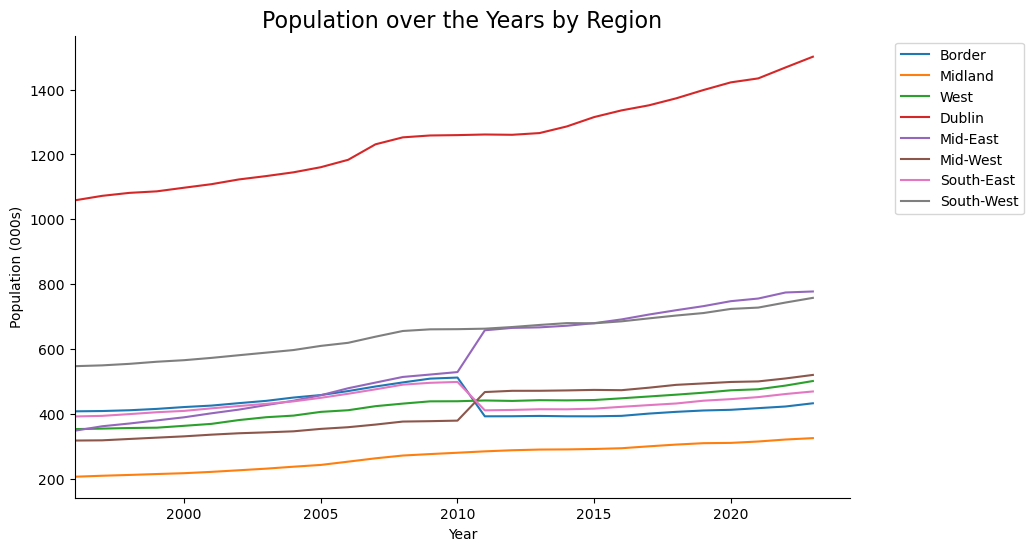

In [76]:
#Creating a line plot showing Population in each regions 
regions = df['Region'].unique()

#Adjusting Plot size
plt.figure(figsize=(10, 6)) 

#Plotting for each region
for region in regions:
    region_data = df[df['Region'] == region]
    plt.plot(region_data['Year'], region_data['VALUE'], label=region)

#Titles, labels and Axis
plt.xlabel('Year')
plt.ylabel("Population (000s)")
plt.title('Population over the Years by Region', fontsize = 16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(1996, None)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#Default colours are aesthetically appropriate so I left unchanged

The first thing we noticed from the above is the odd jumps taking place in 2011, it is important to note that in 2011 there were a number of changes made to the NUTS3 regions:

- The transfer of South Tipperary from the South-East into the Mid-West NUTS3 region; and
- The movement of Louth from the Border to the Mid-East NUTS3 Region.

Whilst this is unfortunate for the continuity of our dataset, it is acurate to the NUT3 regions at the time of the data collection and I will keep this in mind when using this data further in my report.

It is important to note that their are 4 regions which remain geographically unchanged:
- Dublin
- South-West
- West
- Midland

Allignment with Tufte's Principles:

Junk Minimization: The plot is simple and focuses on the data, and it avoids unnecessary distractions. This aligns with Tufte's principle of minimizing chart junk.

Data Integrity: Appropriately labels and a clear title. This ensures that the viewer can soundly interpret the chart. 

#### Section 1.5: Geographical Data Visualisation

Seeing as we are discussing population by region I think it would be appropriate to display this kind of data with a map.

In [77]:
#Install if necessary
#pip install geopandas

In [78]:
#Load in the Geojson file
ireland = gpd.read_file("ireland.geojson")

Source: https://data.gov.ie/dataset?q=geojson+nuts3&res_format=GEOJSON&sort=score+desc%2C+metadata_created+desc

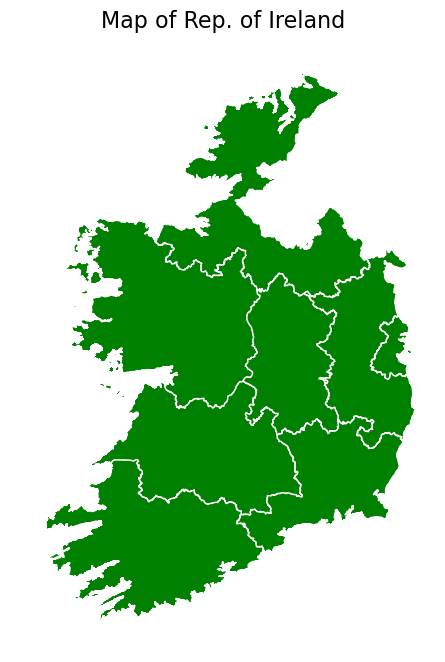

In [79]:
#Make image larger and hide axes
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis('off')

#Plot the map
ireland.plot(ax=ax, color='#008000', edgecolor='white')
plt.title("Map of Rep. of Ireland", fontsize = 16)
plt.show()

#I chose green to represent Ireland

Next I would like to find out where the NUTS3 Regions are stored in the GeoJSON file

In [80]:
#Print the column names to find out where the NUTS3 regions are stored
print(ireland.columns)

Index(['OBJECTID', 'NUTS1', 'NUTS1NAME', 'NUTS2', 'NUTS2NAME', 'NUTS3',
       'NUTS3NAME', 'GUID', 'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')


In [24]:
#This is the column that I am looking for
ireland['NUTS3NAME'].unique()

array(['Border', 'West', 'Mid-West', 'South-East', 'South-West', 'Dublin',
       'Mid-East', 'Midlands'], dtype=object)

I can use these as labels on the map above and display these on the centroids of each respective region

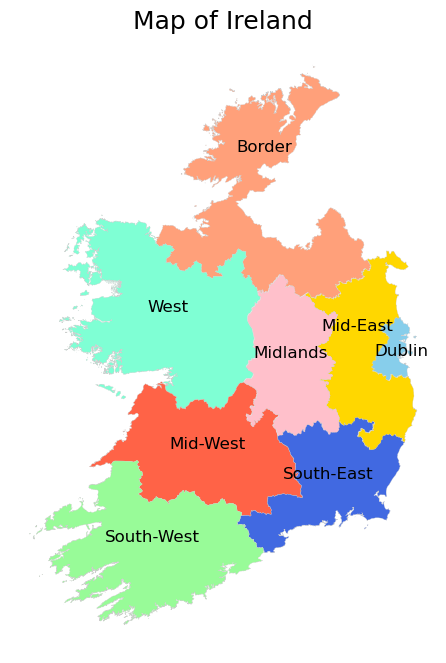

In [25]:
#Aesthetically pleasing colours for each region
#I assigned colours based on the colours that are usually associated with these regions(or counties within these regions).

region_colors = {
    'Border': '#FFA07A',     # Light Salmon
    'West': '#7FFFD4',       # Aquamarine
    'Mid-West': '#FF6347',   # Tomato
    'South-East': '#4169E1', # Royal Blue
    'South-West': '#98FB98', # Pale Green
    'Dublin': '#87CEEB',     # Sky Blue
    'Mid-East': '#FFD700',   # Gold
    'Midlands': '#FFC0CB',   # Pink
}

#Plot map
fig, ax = plt.subplots(figsize=(8, 8))
for region, color in region_colors.items():
    region_data = ireland[ireland['NUTS3NAME'] == region]
    region_data.plot(ax=ax, color=color, edgecolor='0.8', linewidth=0.2)

    #Labels to the centre of each region
    x, y = region_data.centroid.x.values[0], region_data.centroid.y.values[0]

    #Adjust label positions to ensure no overlapping
    if region == 'Mid-East':
        ax.text(x-0.1, y+0.2, region, fontsize=12, ha='center', va='center')
    elif region == 'Border':
        ax.text(x, y+0.4, region, fontsize=12, ha='center', va='center')
    elif region == 'Dublin':
        ax.text(x+0.1, y, region, fontsize=12, ha='center', va='center')
    else:
        ax.text(x, y, region, fontsize=12, ha='center', va='bottom')

#Title, axis
plt.title("Map of Ireland", fontsize = 18)
plt.axis('off')
plt.show()

Now it is time to merge this map to our data by year to create a choropleth map

In [26]:
#Lets take an initial look at our GeoJSON file before we merge 
print(ireland)

   OBJECTID NUTS1 NUTS1NAME NUTS2             NUTS2NAME  NUTS3   NUTS3NAME  \
0         1    IE   Ireland  IE04  Northern and Western  IE041      Border   
1         2    IE   Ireland  IE04  Northern and Western  IE042        West   
2         3    IE   Ireland  IE05              Southern  IE051    Mid-West   
3         4    IE   Ireland  IE05              Southern  IE052  South-East   
4         5    IE   Ireland  IE05              Southern  IE053  South-West   
5         6    IE   Ireland  IE06   Eastern and Midland  IE061      Dublin   
6         7    IE   Ireland  IE06   Eastern and Midland  IE062    Mid-East   
7         8    IE   Ireland  IE06   Eastern and Midland  IE063    Midlands   

                                   GUID  SHAPE_Length  SHAPE_Area  \
0  B1A65D7C-1984-4A87-AD58-0E846812C992     33.955968    1.594920   
1  A69CA800-8D87-4920-A7C1-50426A1D39B4     41.350987    1.941101   
2  42C5C2A5-2D71-4BD1-BDB5-BD7D3198CD78     11.458608    1.396142   
3  27C93D4E-AD0E-4B0C

In [27]:
#I can spot that there is an inconsistent naming convention used when compared to our initial population dataset

#Making the Correction
ireland.at[7, 'NUTS3NAME'] = 'Midland'

In [28]:
#Check my change has worked 
print(ireland)

   OBJECTID NUTS1 NUTS1NAME NUTS2             NUTS2NAME  NUTS3   NUTS3NAME  \
0         1    IE   Ireland  IE04  Northern and Western  IE041      Border   
1         2    IE   Ireland  IE04  Northern and Western  IE042        West   
2         3    IE   Ireland  IE05              Southern  IE051    Mid-West   
3         4    IE   Ireland  IE05              Southern  IE052  South-East   
4         5    IE   Ireland  IE05              Southern  IE053  South-West   
5         6    IE   Ireland  IE06   Eastern and Midland  IE061      Dublin   
6         7    IE   Ireland  IE06   Eastern and Midland  IE062    Mid-East   
7         8    IE   Ireland  IE06   Eastern and Midland  IE063     Midland   

                                   GUID  SHAPE_Length  SHAPE_Area  \
0  B1A65D7C-1984-4A87-AD58-0E846812C992     33.955968    1.594920   
1  A69CA800-8D87-4920-A7C1-50426A1D39B4     41.350987    1.941101   
2  42C5C2A5-2D71-4BD1-BDB5-BD7D3198CD78     11.458608    1.396142   
3  27C93D4E-AD0E-4B0C

Now we want to add on the additional columns to allow us to create the choropleth map 

In [102]:
#Create an new Dataframe to store the results
ireland2 = ireland.copy()

#Initialising the loop
for year in range(1996, 2023):
    
    #Assigning Population columns based on the dictionary
    population_data = {
        'match_column': dfs_by_year[year]['Region'].tolist(),
        f'Population_{year}': dfs_by_year[year]['VALUE'].tolist()}
    
    #Convert population data into a DataFrame
    population_df = pd.DataFrame(population_data)

    #Merge the Dataframe with the population DataFrame based on the matching column
    ireland2 = ireland2.merge(population_df, left_on='NUTS3NAME', right_on='match_column', how='left')

    #Drop the Matching columns
    ireland2 = ireland2.drop(['match_column'], axis=1)

#Print the merged GeoDataFrame
print(ireland2)

   OBJECTID NUTS1 NUTS1NAME NUTS2             NUTS2NAME  NUTS3   NUTS3NAME  \
0         1    IE   Ireland  IE04  Northern and Western  IE041      Border   
1         2    IE   Ireland  IE04  Northern and Western  IE042        West   
2         3    IE   Ireland  IE05              Southern  IE051    Mid-West   
3         4    IE   Ireland  IE05              Southern  IE052  South-East   
4         5    IE   Ireland  IE05              Southern  IE053  South-West   
5         6    IE   Ireland  IE06   Eastern and Midland  IE061      Dublin   
6         7    IE   Ireland  IE06   Eastern and Midland  IE062    Mid-East   
7         8    IE   Ireland  IE06   Eastern and Midland  IE063     Midland   

                                   GUID  SHAPE_Length  SHAPE_Area  ...  \
0  B1A65D7C-1984-4A87-AD58-0E846812C992     33.955968    1.594920  ...   
1  A69CA800-8D87-4920-A7C1-50426A1D39B4     41.350987    1.941101  ...   
2  42C5C2A5-2D71-4BD1-BDB5-BD7D3198CD78     11.458608    1.396142  ...   
3

In [103]:
#Check the columns 
ireland2.columns

Index(['OBJECTID', 'NUTS1', 'NUTS1NAME', 'NUTS2', 'NUTS2NAME', 'NUTS3',
       'NUTS3NAME', 'GUID', 'SHAPE_Length', 'SHAPE_Area', 'geometry',
       'Population_1996', 'Population_1997', 'Population_1998',
       'Population_1999', 'Population_2000', 'Population_2001',
       'Population_2002', 'Population_2003', 'Population_2004',
       'Population_2005', 'Population_2006', 'Population_2007',
       'Population_2008', 'Population_2009', 'Population_2010',
       'Population_2011', 'Population_2012', 'Population_2013',
       'Population_2014', 'Population_2015', 'Population_2016',
       'Population_2017', 'Population_2018', 'Population_2019',
       'Population_2020', 'Population_2021', 'Population_2022'],
      dtype='object')

Now that I have merged the dataset into the correct format I can create my Choropleth map

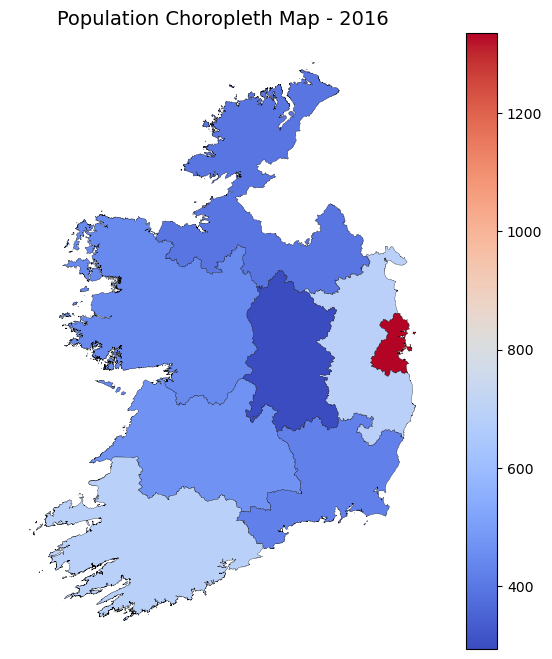

In [104]:
#Create my Choropleth Map for single year, 2016
ax = ireland2.plot(column='Population_2016', 
                   cmap='coolwarm', 
                   legend=True, 
                   figsize=(8, 8), 
                   edgecolor='black', 
                   linewidth=0.2)

#Title and axis
plt.title('Population Choropleth Map - 2016', fontsize = 14)
ax.set_axis_off()

#Show the plot
plt.show()

This map is clearly demonstrating Dublin's high population density so I will remove Dublin to make the map more comparable.

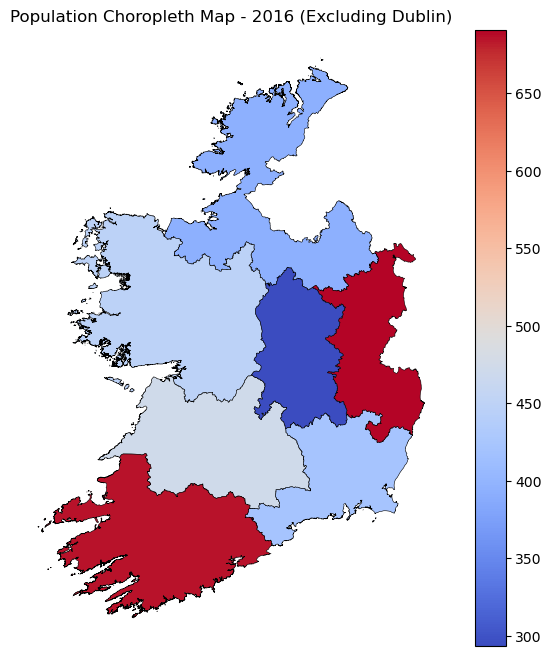

In [105]:
#Have made this variable just in case I would like to exclude another region in future
region_to_exclude = 'Dublin'

#Filter out the region to exclude
filtered_df = ireland2[ireland2['NUTS3NAME'] != region_to_exclude]

#Plot the filtered Dataframe
ax = filtered_df.plot(column='Population_2016', 
                      cmap='coolwarm', 
                      legend=True, 
                      figsize=(8, 8), 
                      edgecolor='black', 
                      linewidth=0.4)

ax.set_axis_off()

#Title and Plot
plt.title('Population Choropleth Map - 2016 (Excluding Dublin)')
plt.show()

The map above emphasises the significant impact that Dublin's population density has on the initial map

Of course, the maps above only show data for 2016

So I would like to extend this visualisation to display the population data for each year

In [81]:
# Useful widget tool I found online
import ipywidgets as widgets
from IPython.display import display

Source: https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Basics.html 

In [107]:
# I will only visualise the data from 2011 - 2023 as pre-2011 the region boundaries were slightly different
years_to_visualize = range(2011, 2023)

# Create a function to update the map based on the selected year
def update_map(year):
    fig, ax = plt.subplots(figsize=(8, 8))
    ireland2.plot(column=f'Population_{year}', 
                  cmap='coolwarm',
                  legend=True, 
                  ax=ax, 
                  edgecolor='black', 
                  linewidth=0.2,
                  vmin=0, 
                  vmax=ireland2[f'Population_2022'].max())                  
    ax.set_axis_off()
    ax.set_title(f'Population Choropleth Map - {year}')  
    plt.show()

# Create a slider widget
year_slider = widgets.IntSlider(
    value=min(years_to_visualize),
    min=min(years_to_visualize),
    max=max(years_to_visualize),
    step=1,
    description='Year:',
    continuous_update=False)  # Update the map only when the slider is released

# Set up the interaction between the slider and the map
widgets.interactive(update_map, year=year_slider)

interactive(children=(IntSlider(value=2011, continuous_update=False, description='Year:', max=2022, min=2011),…

Allignment with Tuft's Principles:

Clarity and Precision: The map is clear and precise. The color scheme chosen (coolwarm) is appropiate and allows the user to distinguish between different population levels. The scale is also fixed across all years. 

I can also display this data in the form of a line chart

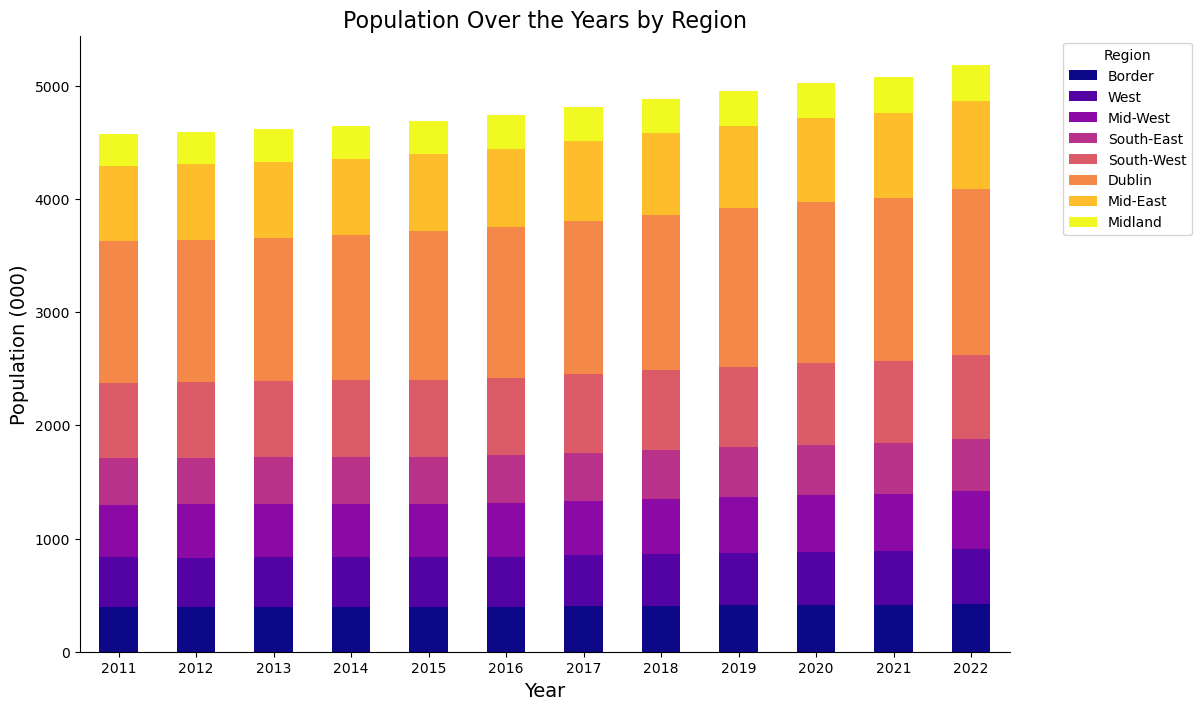

In [108]:
import matplotlib.pyplot as plt

# Select the columns related to population
population_columns = [f'Population_{year}' for year in range(2011, 2023)]

# Transpose the DataFrame for easier plotting
population_data = ireland2[population_columns].transpose()

# Plot a stacked bar chart
ax = population_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='plasma')
#Colours chosen are putely aesthetic

# Customize the plot
plt.title('Population Over the Years by Region', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Population (000)', fontsize=14)
plt.legend(title='Region', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           labels=ireland2['NUTS3NAME'].unique())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([str(year)[-4:] for year in range(2011, 2023)])
plt.xticks(rotation=0)

# Show the plot
plt.show()

#### Section 1.6: Population Growth Rates

In [109]:
#Trimming the dataset to calcuate population growth rates by region 
population_columns = ireland2.filter(regex='^Population')

In [110]:
Pop_df = ireland2[['NUTS3NAME'] + population_columns.columns.tolist()]
print(Pop_df)

,NUTS3NAME,Population_1996,Population_1997,Population_1998,Population_1999,Population_2000,Population_2001,Population_2002,Population_2003,Population_2004,...,Population_2013,Population_2014,Population_2015,Population_2016,Population_2017,Population_2018,Population_2019,Population_2020,Population_2021,Population_2022
0,Border,407.3,408.2,410.6,414.8,420.5,425.0,432.5,439.6,449.8,...,393.1,392.0,391.9,393.3,400.3,405.7,409.9,412.0,417.1,422.2
1,West,352.4,354.0,355.8,356.8,362.6,368.6,380.3,389.1,394.1,...,441.7,441.1,442.2,447.5,453.1,458.7,464.8,472.2,475.4,486.7
2,Mid-West,317.1,317.8,322.0,326.1,330.1,335.3,339.6,342.4,345.6,...,470.7,471.8,473.4,472.5,480.2,489.0,493.4,497.9,499.6,508.7
3,South-East,391.5,393.3,398.7,404.5,408.6,416.5,423.6,430.4,438.0,...,413.7,413.5,415.6,421.2,426.5,431.5,440.1,444.9,451.2,460.7
4,South-West,546.6,549.1,553.8,560.3,565.1,572.2,580.4,588.4,596.4,...,673.8,679.5,678.9,685.0,694.1,702.9,710.6,723.3,727.4,743.0
5,Dublin,1058.3,1072.2,1081.4,1086.1,1097.3,1108.2,1122.8,1133.2,1144.8,...,1265.9,1286.4,1315.3,1335.9,1351.5,1373.1,1398.8,1422.4,1434.6,1468.4
6,Mid-East,347.4,361.2,369.7,379.3,388.9,401.2,412.6,426.5,440.0,...,666.4,671.4,679.3,690.9,705.9,719.3,731.9,747.2,755.3,774.0
7,Midland,205.5,208.5,211.0,213.8,216.4,220.5,225.4,230.4,236.4,...,289.3,289.8,291.1,293.4,299.3,304.7,309.0,309.9,314.2,320.3


In [ ]:
Pop_df.describe()

In [111]:
#Create my Growth Rates Dataframe 
growth_rates_df = Pop_df[['NUTS3NAME']].copy()

#Loop through each pair of years and calculate growth rates
for i in range(1, len(Pop_df.columns) - 1):
    current_year_col = Pop_df.columns[i + 1]
    previous_year_col = Pop_df.columns[i]
    growth_rates_df[current_year_col] = (Pop_df[current_year_col] - Pop_df[previous_year_col]) / Pop_df[previous_year_col]

#Rename the columns
growth_rates_df.columns = ['NUTS3NAME'] + [f"{col.split('_')[1]}" for col in growth_rates_df.columns[1:]]

#Display the table
growth_rates_df

,NUTS3NAME,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Border,0.002210,0.005879,0.010229,0.013742,0.010702,0.017647,0.016416,0.023203,0.017119,...,0.002550,-0.002798,-0.000255,0.003572,0.017798,0.013490,0.010352,0.005123,0.012379,0.012227
1,West,0.004540,0.005085,0.002811,0.016256,0.016547,0.031742,0.023140,0.012850,0.029180,...,0.005234,-0.001358,0.002494,0.011986,0.012514,0.012359,0.013298,0.015921,0.006777,0.023769
2,Mid-West,0.002208,0.013216,0.012733,0.012266,0.015753,0.012824,0.008245,0.009346,0.021701,...,0.000212,0.002337,0.003391,-0.001901,0.016296,0.018326,0.008998,0.009120,0.003414,0.018215
3,South-East,0.004598,0.013730,0.014547,0.010136,0.019334,0.017047,0.016053,0.017658,0.025114,...,0.005102,-0.000483,0.005079,0.013474,0.012583,0.011723,0.019930,0.010907,0.014160,0.021055
4,South-West,0.004574,0.008559,0.011737,0.008567,0.012564,0.014331,0.013784,0.013596,0.021462,...,0.009589,0.008459,-0.000883,0.008985,0.013285,0.012678,0.010955,0.017872,0.005668,0.021446
5,Dublin,0.013134,0.008580,0.004346,0.010312,0.009933,0.013175,0.009263,0.010236,0.013802,...,0.004204,0.016194,0.022466,0.015662,0.011678,0.015982,0.018717,0.016872,0.008577,0.023561
6,Mid-East,0.039724,0.023533,0.025967,0.025310,0.031628,0.028415,0.033689,0.031653,0.038409,...,0.002558,0.007503,0.011766,0.017076,0.021711,0.018983,0.017517,0.020904,0.010840,0.024758
7,Midland,0.014599,0.011990,0.013270,0.012161,0.018946,0.022222,0.022183,0.026042,0.023266,...,0.007312,0.001728,0.004486,0.007901,0.020109,0.018042,0.014112,0.002913,0.013875,0.019414


In [112]:
# Splitting the dataset into 2, considering the inconsistencies in geographical boundaries
pre_2011_df  = growth_rates_df.loc[:, growth_rates_df.columns < '2011']
post_2011_df = growth_rates_df.loc[:, growth_rates_df.columns > '2011']

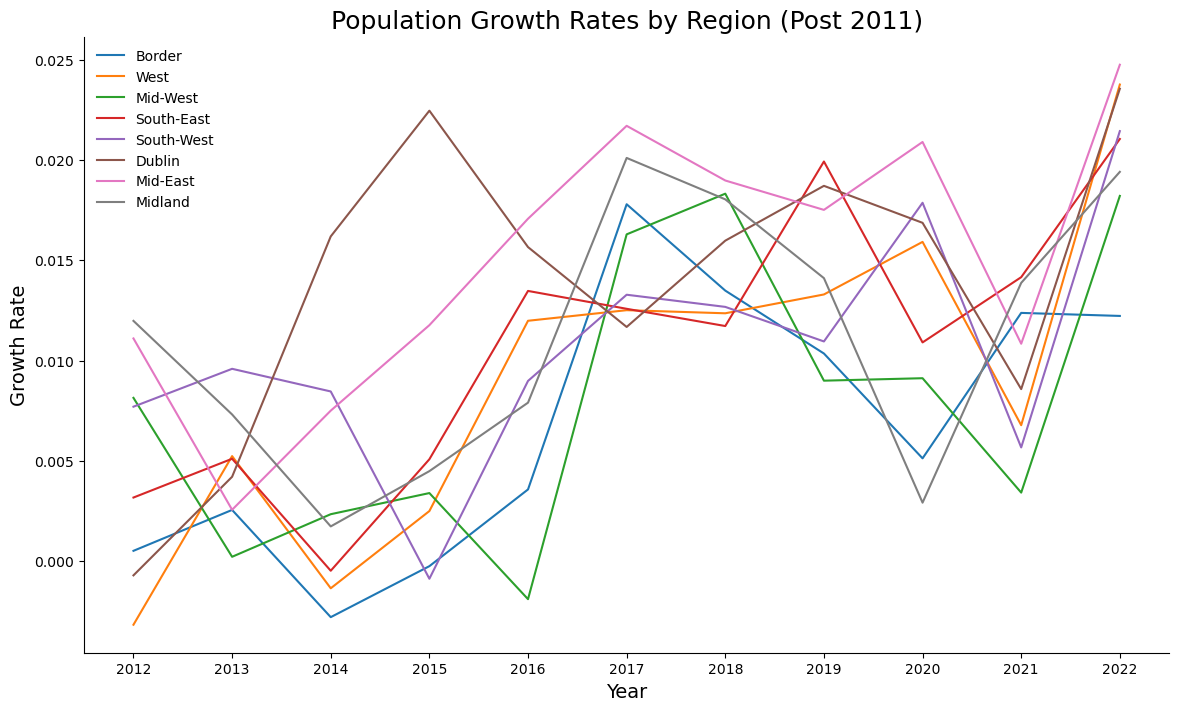

In [113]:
#Choosing which df to use
df = pd.DataFrame(post_2011_df)
df.set_index('NUTS3NAME', inplace=True)

#Plotting
plt.figure(figsize=(14, 8))
for region in df.index:
    plt.plot(df.columns, df.loc[region], label=region)

#Edit the axis and titles 
plt.title('Population Growth Rates by Region (Post 2011)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Growth Rate', fontsize=14)
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

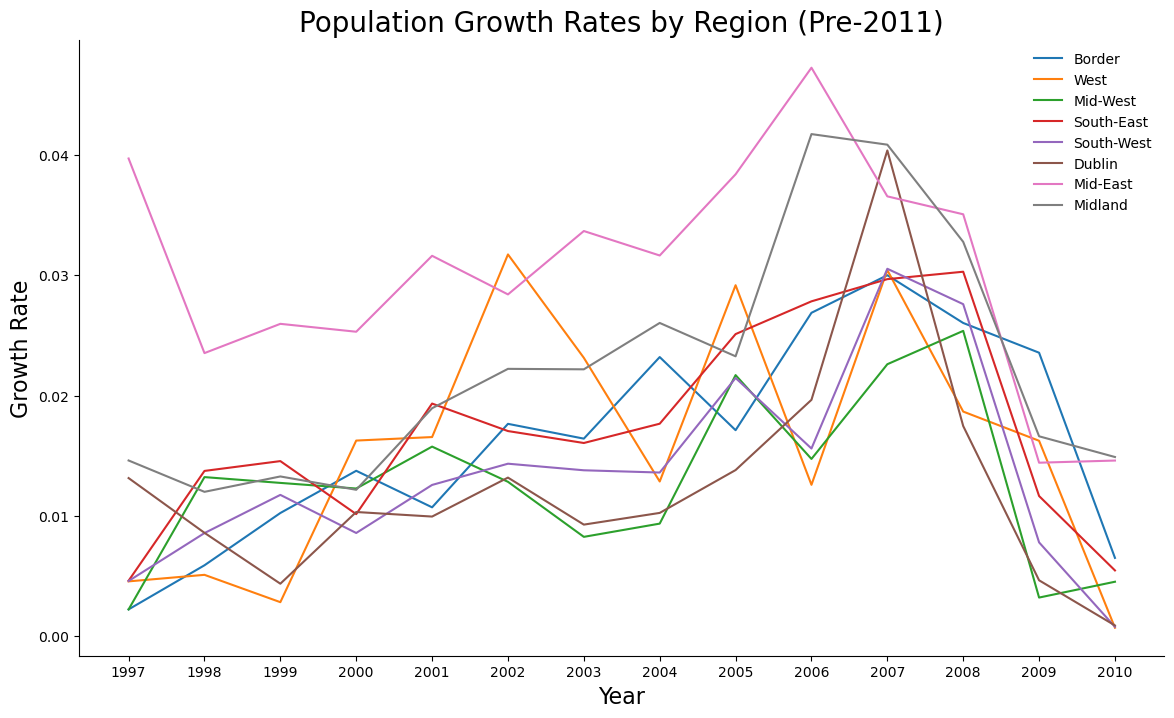

In [114]:
#Choosing which df to use
df = pd.DataFrame(pre_2011_df)
df = df.set_index(ireland2['NUTS3NAME'])

#Plotting
plt.figure(figsize=(14, 8))
for region in df.index:
    plt.plot(df.columns, df.loc[region], label=region)

#Edit the axis and titles 
plt.title('Population Growth Rates by Region (Pre-2011)', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Growth Rate', fontsize=16)
plt.legend(fontsize=10, frameon=False)
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

#### Section 1.7: Projection of Population using a Regression Model

In [115]:
#Adjusting the Dataframe into the desired format
df = Pop_df.copy()

#Rename the columns
df.columns = [col.split('_')[1] if '_' in col else col for col in Pop_df.columns]

#Add a Total column
df.loc[len(Pop_df.index)] = ['Total'] + df.iloc[:, 1:].sum().tolist()

#Transpose the DataFrame
df = df.set_index('NUTS3NAME').T

#Add Heading
df.index.name = 'Year'

#Multiply by 1000
df *= 1000

print(df.head(5))

NUTS3NAME    Border      West  Mid-West  South-East  South-West     Dublin  \
Year                                                                         
1996       407300.0  352400.0  317100.0    391500.0    546600.0  1058300.0   
1997       408200.0  354000.0  317800.0    393300.0    549100.0  1072200.0   
1998       410600.0  355800.0  322000.0    398700.0    553800.0  1081400.0   
1999       414800.0  356800.0  326100.0    404500.0    560300.0  1086100.0   
2000       420500.0  362600.0  330100.0    408600.0    565100.0  1097300.0   

NUTS3NAME  Mid-East   Midland      Total  
Year                                      
1996       347400.0  205500.0  3626100.0  
1997       361200.0  208500.0  3664300.0  
1998       369700.0  211000.0  3703000.0  
1999       379300.0  213800.0  3741700.0  
2000       388900.0  216400.0  3789500.0  


In [116]:
# I have made this so that it can be easily adjusted for any specific region

X = df.index.values.reshape(-1, 1)
y = df['Total']
#y = df['Dublin']
#y = df['West']

In [117]:
#Use the first 20 data points for training and the rest for testing
n_train = 20

In [118]:
# I have taken this very useful function from Dr.Muhammad Iqbal's Saturday Lecture (04/11/23)

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]    
    
    regressor.fit(X_train, y_train)
    
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize = (16,8))

    plt.plot(range(n_train), y_train, label = "train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label = "test")
    plt.plot(range(n_train), y_pred_train, '--', label = "prediction train")
    plt.xlim(0, len(y_train) + len(y_test))
    
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label = "prediction test")
    plt.legend(loc=(1.01, 0.8), prop={'size': 20})
    plt.xlabel("Year", fontsize = 20)
    plt.ylabel("Population", fontsize = 20)

Source Reference for Code
- Introduction to Machine Learning Third Edition, The MIT Press Cambridge, London, England, 2014.

Test-set R^2: 0.58


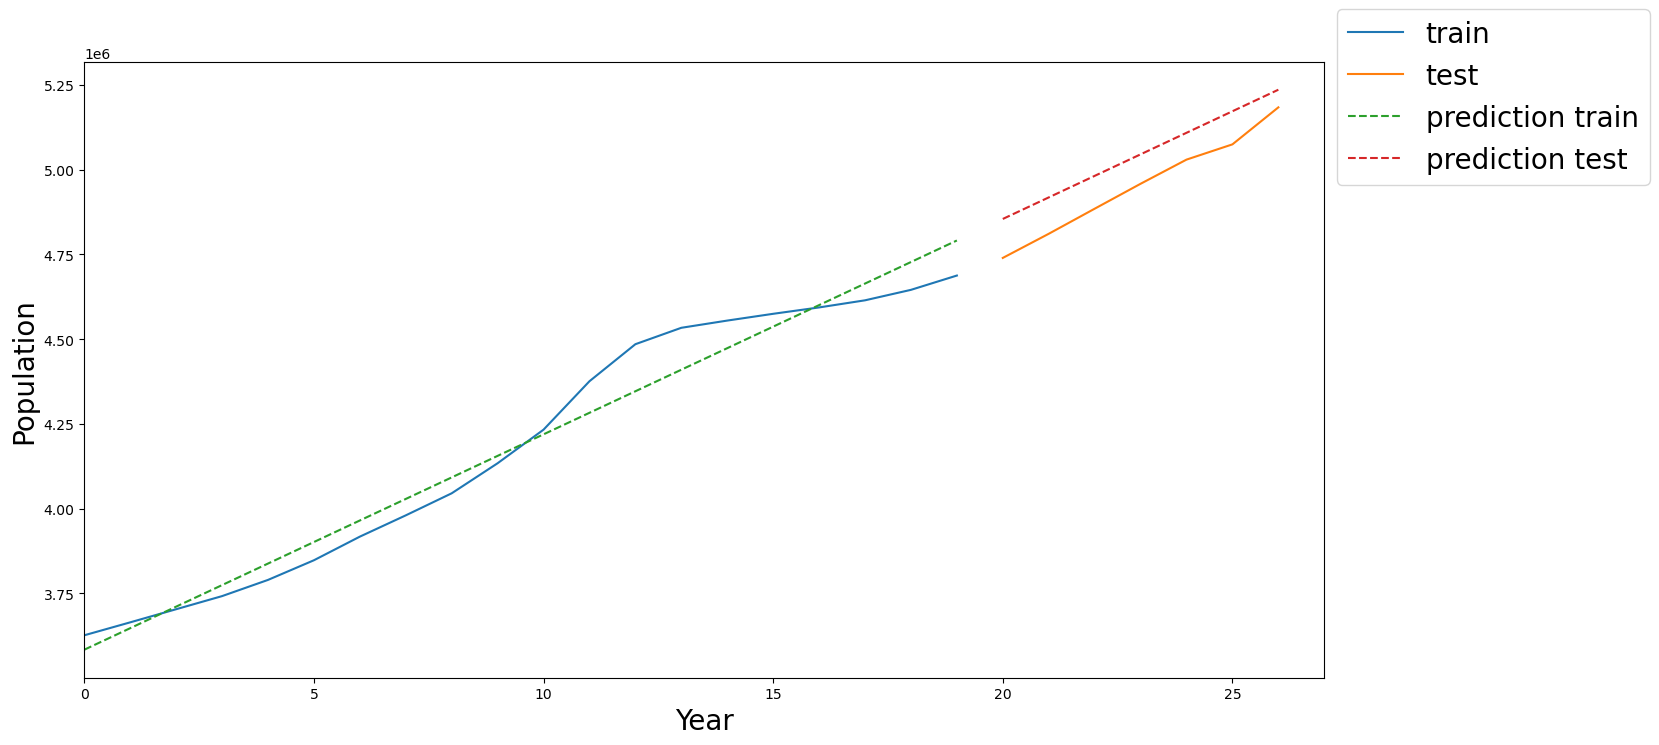

In [119]:
#Call a method eval_on_features() to evaluate R^2 and plot
eval_on_features(X, y, LinearRegression())

Test-set R^2: 0.59


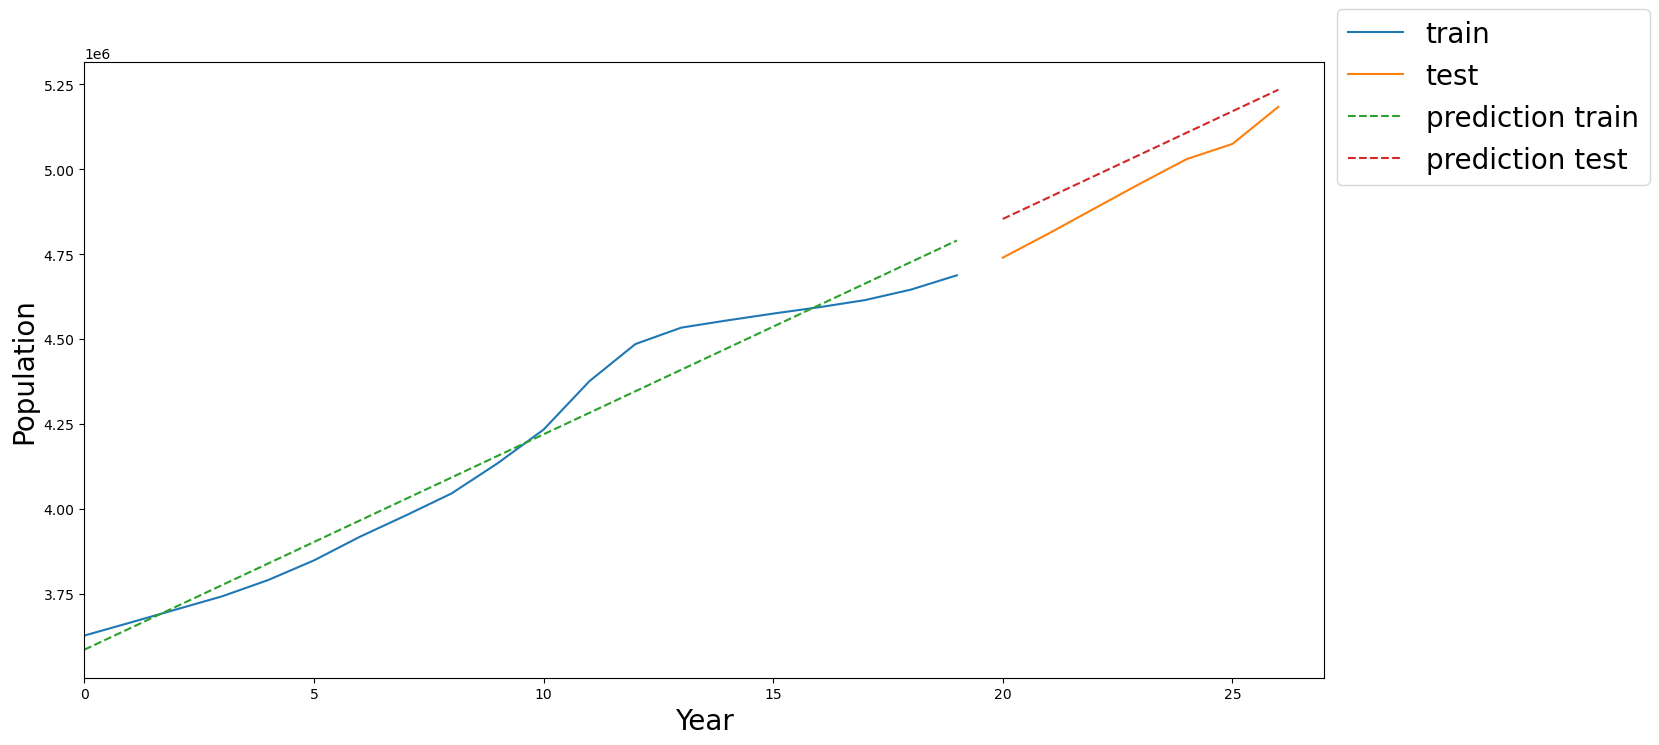

In [120]:
#Call a method eval_on_features() to evaluate R^2 and plot 
eval_on_features(X, y, Ridge())

We can see from above the the Ridge Regression gives a slightly improved R^2 value. I also attempted to use Random Forrest regression but with poor results. It is important to note that there are only are 26 data points in this dataframe so I thought it was not appropriate to spend to much time on this and focus my efforts on a larger dataset further along in my report. 

#### Section 1.8: Application of the Normal Distribution 

I theroised that the Population change would be normally distributed so I decided to put this to the test

In [121]:
#Creating the Change df
df['Population Change'] = df['Total'].diff()
change_df = df[['Population Change']].copy()
change_df.reset_index(level=0, inplace=True)
change_df.columns = ['Year', 'Population Change']
change_df = change_df.dropna()
print(change_df.head(5))

   Year  Population Change
1  1997            38200.0
2  1998            38700.0
3  1999            38700.0
4  2000            47800.0
5  2001            58000.0


In [122]:
#Extracting statistics
mean_change = np.mean(change_df['Population Change'])
std_dev_change = np.std(change_df['Population Change'])
median_change = np.median(change_df['Population Change'])
percentile_75 = np.percentile(change_df['Population Change'], 75)
percentile_25 = np.percentile(change_df['Population Change'], 25)

print(f"Mean Population Change: {mean_change:.2f}")
print(f"Median Population Change: {median_change:.2f}")
print(f"75th Percentile Population Change: {percentile_75:.2f}")
print(f"25th Percentile Population Change: {percentile_25:.2f}")
print(f"S.D of Population Change: {std_dev_change:.2f}")

Mean Population Change: 59919.23
Median Population Change: 55000.00
75th Percentile Population Change: 73025.00
25th Percentile Population Change: 38700.00
S.D of Population Change: 30556.82


Section 1.8.1: Boxplot

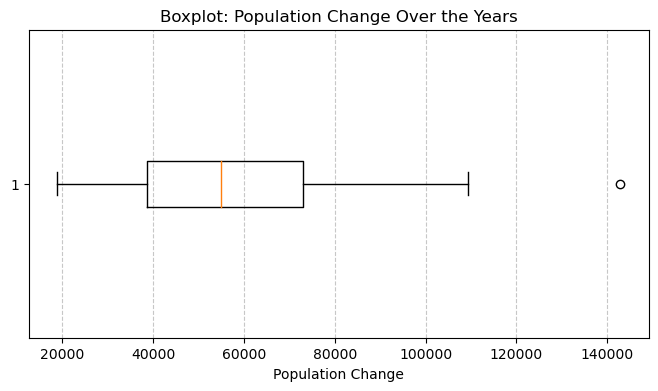

In [123]:
#Create a boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(change_df['Population Change'], vert=False)
plt.title('Boxplot: Population Change Over the Years')
plt.xlabel('Population Change')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

If the dataset follows a normal distribution, the boxplot will show a symmetrical box with the median line in the center. 

Outliers are also evident. We can see this in the outling population change value is 2007 which was a 140,000 population increase.

Section 1.8.2: Normal Distribution Visualisation

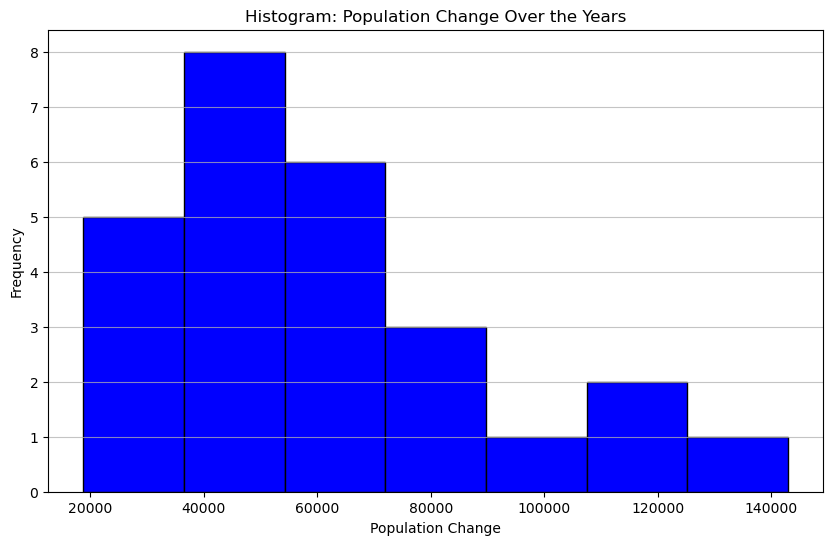

In [124]:
#Create a frequency histogram
plt.figure(figsize=(10, 6))
plt.hist(change_df['Population Change'], bins=7, color='blue', edgecolor='black')
plt.title('Histogram: Population Change Over the Years')
plt.xlabel('Population Change')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Somewhat similar to the bell-shape we would expect to see with a normal distribution

#### Section 1.8.3: Shapiro-Wilk Test

Finally, I decided to test this using a Shapiro-Wilk test

In [125]:
#Shapiro-Wilk test
statistic, p_value = shapiro(change_df['Population Change'])

#Interpret the results
alpha = 0.05
print(f"Shapiro-Wilk Test Stat: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value > alpha:
    print("The data appears to be normally distributed")
else:
    print("The data does not appear to be normally distributed")

Shapiro-Wilk Test Stat: 0.9370
P-value: 0.1141
The data appears to be normally distributed


End